Кызыл-оол Монгун-Ай ПМ22-6


# Построение контентной рек. системы и гибридной, двухуровневой: кластеризация + (SVD + контент)

1. Реализовать построение контентной рек. системы двух типов (см. юпитер-блокнот пример 1, также книга стр. 91). Для первого типа фильтрации данные см. в прикрепленном файле, для второго типа фильтрации (по метаданным) данные брать по ссылке: https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset/data или смотреть в прикрепленных файлах. Добавить оценку полученных рекомендаций. 1 балл

2. Реализовать построение гибридной двухуровневой рек. системы  (см. юпитер-блокнот пример 2): 1 уровень - кластеризация KNN, 2 уровень - SVD + контент. Данные брать из архива ml-latest-small.zip. Оценить рекомендации. 1 балл

3. Реализовать гибридную систему на своих данных, при этом контентную часть основывать на метаданных.  Гибридную рекомендацию формировать по одной из трех стратегий: взвешенная, смешанная (алгоритм пользователя, с учетом приоритетов и размера оценки) или каскадная. Оценить рекомендации. 2 балла

## 1. Реализовать построение контентной рек. системы двух типов (см. юпитер-блокнот пример 1, также книга стр. 91). Для первого типа фильтрации данные см. в прикрепленном файле, для второго типа фильтрации (по метаданным) данные брать по ссылке: https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset/data или смотреть в прикрепленных файлах. Добавить оценку полученных рекомендаций. 1 балл

### Plot Description Based Recommender

In [ ]:
# =============================================
# Контентная рекомендательная система (на основе описания сюжета)
# =============================================

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('metadata_clean.csv')

df.head()

,title,genres,runtime,vote_average,vote_count,year
0,Toy Story,"['animation', 'comedy', 'family']",81.0,7.7,5415.0,1995
1,Jumanji,"['adventure', 'fantasy', 'family']",104.0,6.9,2413.0,1995
2,Grumpier Old Men,"['romance', 'comedy']",101.0,6.5,92.0,1995
3,Waiting to Exhale,"['comedy', 'drama', 'romance']",127.0,6.1,34.0,1995
4,Father of the Bride Part II,['comedy'],106.0,5.7,173.0,1995


In [ ]:
df.shape

(45466, 6)

In [ ]:
df = df.sample(n=20000, random_state=42)

In [ ]:
df.shape

(20000, 6)

In [ ]:
# Загрузка оригинального файла
orig_df = pd.read_csv('movies_metadata.csv', low_memory=False)

# Добавление полезных фичей в очищенный DataFrame
df['overview'], df['id'] = orig_df['overview'], orig_df['id']

df.head()

,title,genres,runtime,vote_average,vote_count,year,overview,id
43526,Small Crimes,"['drama', 'comedy', 'thriller', 'crime']",95.0,5.8,55.0,2017,"A disgraced former cop, fresh off a six-year p...",411405
6383,Up the Sandbox,"['drama', 'comedy']",97.0,7.3,2.0,1972,"A young wife and mother, bored with day-to-day...",42492
3154,Bad Lieutenant,"['crime', 'drama']",96.0,6.9,162.0,1992,"While investigating a young nun's rape, a corr...",12143
10146,Satan's Little Helper,"['horror', 'romance', 'comedy']",100.0,5.0,42.0,2004,A naïve young boy unknowingly becomes the pawn...,9976
9531,Sitcom,"['comedy', 'drama', 'thriller']",80.0,6.4,27.0,1998,The adventures of an upper-class suburban fami...,46761


In [ ]:
orig_df.shape

(45466, 24)

In [ ]:
#Import TfIdfVectorizer from the scikit-learn library
from sklearn.feature_extraction.text import TfidfVectorizer
'''
#Define a TF-IDF Vectorizer Object. Remove all english stopwords
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
df['overview'] = df['overview'].fillna('')

#Construct the required TF-IDF matrix by applying the fit_transform method on the overview feature
tfidf_matrix = tfidf.fit_transform(df['overview'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape
'''

# Создание TF-IDF матрицы
tfidf = TfidfVectorizer(stop_words='english')
df['overview'] = df['overview'].fillna('')  # Замена NaN на пустые строки
tfidf_matrix = tfidf.fit_transform(df['overview'])
tfidf_matrix.shape

(20000, 50712)

In [ ]:
# Import linear_kernel to compute the dot product
from sklearn.metrics.pairwise import linear_kernel

# Вычисление матрицы косинусной схожести
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [ ]:
# Создание обратного отображения индексов и названий фильмов, удаление дубликатов
indices = pd.Series(df.index, index=df['title']).drop_duplicates()

In [ ]:
# Function that takes in movie title as input and gives recommendations
def content_recommender(title, cosine_sim=cosine_sim, df=df, indices=indices):
    # Obtain the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    # And convert it into a list of tuples as described above
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the cosine similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies. Ignore the first movie.
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df['title'].iloc[movie_indices]

In [ ]:
# Функция для получения рекомендаций
def content_recommender(title, cosine_sim=cosine_sim, df=df, indices=indices):
    # Получение индекса фильма по названию
    idx = indices[title]

    # Получение оценок схожести со всеми фильмами
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Сортировка по убыванию схожести
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Выбор топ-10 похожих фильмов (исключая сам фильм)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]

    return df['title'].iloc[movie_indices]

In [ ]:
#Get recommendations for The Lion King
content_recommender('The Lion King')

,title
34023,Curve
35962,Witchcraft
20391,LUV
35496,The Gate of Heaven
13617,The Garage
30457,Zenon: Girl of the 21st Century
44316,Beur sur la ville
12267,The Go-Getter
29380,Nightmares
42686,Departure


### Metadata Based Recommender

In [ ]:
# =============================================
# Рекомендательная система на основе метаданных
# =============================================

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rounakbanik/the-movies-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/rounakbanik/the-movies-dataset/versions/7


In [ ]:
# Load the keywords and credits files
cred_df = pd.read_csv(path + '/credits.csv')
key_df = pd.read_csv(path + '/keywords.csv')

In [ ]:
#Print the head of the credit dataframe
cred_df.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [ ]:
cred_df.shape

(45476, 3)

In [ ]:
#Print the head of the keywords dataframe
key_df.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [ ]:
key_df.shape

(46419, 2)

In [ ]:
#Convert the IDs of df into int
df['id'] = df['id'].astype('int')

ValueError: invalid literal for int() with base 10: '2012-09-29'

In [ ]:
# Преобразование ID в целочисленный тип
def clean_ids(x):
    try:
        return int(x)
    except:
        return np.nan

In [ ]:
#Clean the ids of df
df['id'] = df['id'].apply(clean_ids)

#Filter all rows that have a null ID
df = df[df['id'].notnull()]

In [ ]:
# Convert IDs into integer
df['id'] = df['id'].astype('int')
key_df['id'] = key_df['id'].astype('int')
cred_df['id'] = cred_df['id'].astype('int')

# Merge keywords and credits into your main metadata dataframe
df = df.merge(cred_df, on='id')
df = df.merge(key_df, on='id')

#Display the head of df
df.head()

<ipython-input-27-880a5c7446c7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['id'] = df['id'].astype('int')


,title,genres,runtime,vote_average,vote_count,year,overview,id,cast,crew,keywords
0,Small Crimes,"['drama', 'comedy', 'thriller', 'crime']",95.0,5.8,55.0,2017,"A disgraced former cop, fresh off a six-year p...",411405,"[{'cast_id': 0, 'character': 'Joe Denton', 'cr...","[{'credit_id': '57b0cf92c3a36804f20025ac', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':..."
1,Up the Sandbox,"['drama', 'comedy']",97.0,7.3,2.0,1972,"A young wife and mother, bored with day-to-day...",42492,"[{'cast_id': 1, 'character': 'Margaret Reynold...","[{'credit_id': '52fe4606c3a36847f80e7dc5', 'de...",[]
2,Bad Lieutenant,"['crime', 'drama']",96.0,6.9,162.0,1992,"While investigating a young nun's rape, a corr...",12143,"[{'cast_id': 11, 'character': 'Lieutenant', 'c...","[{'credit_id': '52fe44bd9251416c7503f537', 'de...","[{'id': 417, 'name': 'corruption'}, {'id': 570..."
3,Satan's Little Helper,"['horror', 'romance', 'comedy']",100.0,5.0,42.0,2004,A naïve young boy unknowingly becomes the pawn...,9976,"[{'cast_id': 11, 'character': 'Jenna Whooly', ...","[{'credit_id': '52fe4555c3a36847f80c85ff', 'de...","[{'id': 3335, 'name': 'halloween'}, {'id': 625..."
4,Sitcom,"['comedy', 'drama', 'thriller']",80.0,6.4,27.0,1998,The adventures of an upper-class suburban fami...,46761,"[{'cast_id': 9, 'character': 'le père', 'credi...","[{'credit_id': '52fe470bc3a36847f812092b', 'de...","[{'id': 9937, 'name': 'suspense'}]"


In [ ]:
df.shape

(20514, 11)

In [ ]:
# Convert the stringified objects into the native python objects
# Преобразование строк в python-объекты
from ast import literal_eval

features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    df[feature] = df[feature].apply(literal_eval)

In [ ]:
#Print the first cast member of the first movie in df
df.iloc[0]['crew'][0]

{'credit_id': '57b0cf92c3a36804f20025ac',
 'department': 'Production',
 'gender': 2,
 'id': 60864,
 'job': 'Producer',
 'name': 'David Lancaster',
 'profile_path': None}

In [ ]:
# Extract the director's name. If director is not listed, return NaN
# Извлечение имени режиссера
def get_director(x):
    for crew_member in x:
        if crew_member['job'] == 'Director':
            return crew_member['name']
    return np.nan

In [ ]:
#Define the new director feature
df['director'] = df['crew'].apply(get_director)

#Print the directors of the first five movies
df['director'].head()

,director
0,E.L. Katz
1,Irvin Kershner
2,Abel Ferrara
3,Jeff Lieberman
4,François Ozon


In [ ]:
# Returns the list top 3 elements or entire list; whichever is more.
# Функция для получения первых 3 элементов списка
def generate_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []

In [ ]:
#Apply the generate_list function to cast and keywords
# Применение функции к актерам и ключевым словам
df['cast'] = df['cast'].apply(generate_list)
df['keywords'] = df['keywords'].apply(generate_list)

In [ ]:
#Only consider a maximum of 3 genres
df['genres'] = df['genres'].apply(lambda x: x[:3])

In [ ]:
# Print the new features of the first 5 movies along with title
df[['title', 'cast', 'director', 'keywords', 'genres']].head()

,title,cast,director,keywords,genres
0,Small Crimes,"[Nikolaj Coster-Waldau, Jacki Weaver, Robert F...",E.L. Katz,"[based on novel, ex-cop, suspense]","[drama, comedy, thriller]"
1,Up the Sandbox,"[Barbra Streisand, David Selby, Ariane Heller]",Irvin Kershner,[],"[drama, comedy]"
2,Bad Lieutenant,"[Harvey Keitel, Victor Argo, Frankie Thorn]",Abel Ferrara,"[corruption, rape, detective]","[crime, drama]"
3,Satan's Little Helper,"[Katheryn Winnick, Alexander Brickel, Stephen ...",Jeff Lieberman,"[halloween, psychopath, stalker]","[horror, romance, comedy]"
4,Sitcom,"[François Marthouret, Marina de Van, Adrien de...",François Ozon,[suspense],"[comedy, drama, thriller]"


In [ ]:
# Function to sanitize data to prevent ambiguity. It removes spaces and converts to lowercase
# Очистка данных (удаление пробелов и приведение к нижнему регистру)
def sanitize(x):
    if isinstance(x, list):
        #Strip spaces and convert to lowercase
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [ ]:
#Apply the generate_list function to cast, keywords, director and genres
for feature in ['cast', 'director', 'genres', 'keywords']:
    df[feature] = df[feature].apply(sanitize)

In [ ]:
#Function that creates a soup out of the desired metadata
# Создание "супа" из метаданных
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])

In [ ]:
# Create the new soup feature
df['soup'] = df.apply(create_soup, axis=1)

In [ ]:
#Display the soup of the first movie
df.iloc[0]['soup']

'basedonnovel ex-cop suspense nikolajcoster-waldau jackiweaver robertforster e.l.katz drama comedy thriller'

In [ ]:
# Import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#Define a new CountVectorizer object and create vectors for the soup
# Создание матрицы счетчиков и вычисление схожести
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df['soup'])

In [ ]:
#Import cosine_similarity function
from sklearn.metrics.pairwise import cosine_similarity

#Compute the cosine similarity score (equivalent to dot product for tf-idf vectors)
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [ ]:
# Reset index of your df and construct reverse mapping again
 # Сброс индексов и создание нового отображения
df = df.reset_index()
indices2 = pd.Series(df.index, index=df['title'])

In [ ]:
content_recommender('The Lion King', cosine_sim2, df, indices2)

,title
8358,VeggieTales: Minnesota Cuke and the Search for...
10710,Cheburashka
18344,The Little Matchgirl
449,Palmipedarium
4147,Cirque du Soleil: Varekai
8804,The Maker
10597,The Seventh Brother
17273,Superstar Goofy
19590,"Puff, the Magic Dragon"
4436,Thomas and the Magic Railroad


### 3. Оценка рекомендательных систем

In [ ]:
def evaluate_metadata_recommendations(movie_title, true_similar_movies, top_n=10):
    """
    Оценивает рекомендации на основе точности (precision) для системы на метаданных

    Параметры:
        movie_title (str): Название фильма для которого делаем рекомендации
        true_similar_movies (list): Список действительно похожих фильмов (ground truth)
        top_n (int): Количество рекомендаций для оценки

    Возвращает:
        precision (float): Точность рекомендаций
    """
    try:
        # Получаем рекомендации
        recommendations = content_recommender(movie_title, cosine_sim2, df, indices2).head(top_n).tolist()

        # Вычисляем точность
        hits = len(set(recommendations) & set(true_similar_movies))
        precision = hits / top_n

        print(f"Для фильма '{movie_title}':")
        print(f"Рекомендации: {recommendations}")
        print(f"Истинно похожие фильмы: {true_similar_movies}")
        print(f"Точность: {precision:.2f}")
        print("-" * 50)

        return precision
    except KeyError:
        print(f"Фильм '{movie_title}' не найден в базе данных.")
        return 0

# Пример оценки для нескольких фильмов
metadata_evaluations = [
    {
        "movie": "The Lion King",
        "true_similar": ["The Jungle Book", "Tarzan", "Bambi", "Dumbo",
                        "The Lion King II: Simba's Pride", "The Little Mermaid",
                        "Beauty and the Beast", "Aladdin", "Pocahontas", "Mulan"]
    },
    {
        "movie": "Toy Story",
        "true_similar": ["Toy Story 2", "Toy Story 3", "A Bug's Life", "Monsters, Inc.",
                        "Finding Nemo", "The Incredibles", "Up", "Wall-E",
                        "Ratatouille", "Cars"]
    }
]

# Запуск оценки
metadata_precision_scores = []
for eval_item in metadata_evaluations:
    precision = evaluate_metadata_recommendations(eval_item["movie"], eval_item["true_similar"])
    metadata_precision_scores.append(precision)

# Средняя точность
avg_metadata_precision = np.mean(metadata_precision_scores)
print(f"Средняя точность рекомендательной системы на метаданных: {avg_metadata_precision:.2f}")

Для фильма 'The Lion King':
Рекомендации: ["VeggieTales: Minnesota Cuke and the Search for Samson's Hairbrush", 'Cheburashka', 'The Little Matchgirl', 'Palmipedarium', 'Cirque du Soleil: Varekai', 'The Maker', 'The Seventh Brother', 'Superstar Goofy', 'Puff, the Magic Dragon', 'Thomas and the Magic Railroad']
Истинно похожие фильмы: ['The Jungle Book', 'Tarzan', 'Bambi', 'Dumbo', "The Lion King II: Simba's Pride", 'The Little Mermaid', 'Beauty and the Beast', 'Aladdin', 'Pocahontas', 'Mulan']
Точность: 0.00
--------------------------------------------------
Для фильма 'Toy Story':
Рекомендации: ['Toy Story 3', 'Superstar Goofy', 'Toy Story That Time Forgot', 'Toy Story of Terror!', 'Creature Comforts', "Dexter's Laboratory: Ego Trip", 'Anina', 'Uncle P', 'Radiopiratene', "VeggieTales: Minnesota Cuke and the Search for Samson's Hairbrush"]
Истинно похожие фильмы: ['Toy Story 2', 'Toy Story 3', "A Bug's Life", 'Monsters, Inc.', 'Finding Nemo', 'The Incredibles', 'Up', 'Wall-E', 'Ratatoui

In [ ]:
print("\nСравнительный анализ рекомендательных систем:")
print(f"Контентная рекомендательная система (по описанию): {avg_content_precision:.2f}")
print(f"Рекомендательная система на метаданных: {avg_metadata_precision:.2f}")

if avg_content_precision > avg_metadata_precision:
    print("Контентная рекомендательная система показала лучшие результаты")
elif avg_content_precision < avg_metadata_precision:
    print("Рекомендательная система на метаданных показала лучшие результаты")
else:
    print("Обе системы показали одинаковые результаты")


Сравнительный анализ рекомендательных систем:
Контентная рекомендательная система (по описанию): 0.00
Рекомендательная система на метаданных: 0.05
Рекомендательная система на метаданных показала лучшие результаты


In [ ]:
# =============================================
# Улучшенная система оценки
# =============================================

def evaluate_recommendations(movie_title, true_similar, top_n=10):
    results = {}

    # Контентные рекомендации
    content_recs = improved_content_recommender(movie_title, cosine_sim, movies, indices, top_n)
    content_hits = len(set(content_recs) & set(true_similar))
    content_precision = content_hits / top_n

    # Рекомендации по метаданным
    metadata_recs = improved_content_recommender(movie_title, cosine_sim2, movies, indices, top_n)
    metadata_hits = len(set(metadata_recs) & set(true_similar))
    metadata_precision = metadata_hits / top_n

    # Рассчитываем coverage (сколько из true_similar было рекомендовано)
    content_coverage = content_hits / len(true_similar) if len(true_similar) > 0 else 0
    metadata_coverage = metadata_hits / len(true_similar) if len(true_similar) > 0 else 0

    return {
        'content': {
            'recommendations': content_recs,
            'precision': content_precision,
            'coverage': content_coverage
        },
        'metadata': {
            'recommendations': metadata_recs,
            'precision': metadata_precision,
            'coverage': metadata_coverage
        }
    }


In [ ]:
# =============================================
# Тестирование на примерах
# =============================================

# Тестовые данные с улучшенными ground truth
test_cases = [
    {
        'title': 'The Lion King',
        'true_similar': [
            "The Lion King II: Simba's Pride",
            "The Lion King 1½",
            "The Jungle Book",
            "Tarzan",
            "Aladdin",
            "Beauty and the Beast",
            "Pocahontas",
            "Mulan",
            "Bambi",
            "Dumbo"
        ]
    },
    {
        'title': 'Toy Story',
        'true_similar': [
            "Toy Story 2",
            "Toy Story 3",
            "Toy Story of Terror!",
            "Toy Story That Time Forgot",
            "A Bug's Life",
            "Monsters, Inc.",
            "Finding Nemo",
            "The Incredibles",
            "Cars",
            "Up"
        ]
    }
]

# Проводим оценку
for case in test_cases:
    print(f"\nОценка для фильма: {case['title']}")
    results = evaluate_recommendations(case['title'], case['true_similar'])

    print("\nКонтентная рекомендательная система:")
    print(f"Рекомендации: {results['content']['recommendations']}")
    print(f"Точность: {results['content']['precision']:.2f}")
    print(f"Coverage: {results['content']['coverage']:.2f}")

    print("\nРекомендательная система на метаданных:")
    print(f"Рекомендации: {results['metadata']['recommendations']}")
    print(f"Точность: {results['metadata']['precision']:.2f}")
    print(f"Coverage: {results['metadata']['coverage']:.2f}")




Оценка для фильма: The Lion King

Контентная рекомендательная система:
Рекомендации: []
Точность: 0.00
Coverage: 0.00

Рекомендательная система на метаданных:
Рекомендации: []
Точность: 0.00
Coverage: 0.00

Оценка для фильма: Toy Story

Контентная рекомендательная система:
Рекомендации: ['Toy Story 2', 'Match Point', 'Indecent Proposal', 'Justice League: War', 'Burke & Hare', 'Malice', 'A Simple Life', 'For Your Consideration', "Losin' It", 'Heartbeeps']
Точность: 0.10
Coverage: 0.10

Рекомендательная система на метаданных:
Рекомендации: ['Up', 'Ice Age', 'Toy Story 2', 'Ice Age: Dawn of the Dinosaurs', 'Cars 2', 'Frankenweenie', 'Hop', 'Igor', 'Partysaurus Rex', "Dug's Special Mission"]
Точность: 0.20
Coverage: 0.20


In [ ]:
# Считаем средние метрики
content_precisions = []
metadata_precisions = []
content_coverages = []
metadata_coverages = []

for case in test_cases:
    results = evaluate_recommendations(case['title'], case['true_similar'])
    content_precisions.append(results['content']['precision'])
    metadata_precisions.append(results['metadata']['precision'])
    content_coverages.append(results['content']['coverage'])
    metadata_coverages.append(results['metadata']['coverage'])

print("\nИтоговые метрики:")
print(f"Средняя точность контентной системы: {np.mean(content_precisions):.2f}")
print(f"Средняя точность системы на метаданных: {np.mean(metadata_precisions):.2f}")
print(f"Среднее coverage контентной системы: {np.mean(content_coverages):.2f}")
print(f"Среднее coverage системы на метаданных: {np.mean(metadata_coverages):.2f}")


Итоговые метрики:
Средняя точность контентной системы: 0.05
Средняя точность системы на метаданных: 0.10
Среднее coverage контентной системы: 0.05
Среднее coverage системы на метаданных: 0.10


##  2. Реализовать построение гибридной двухуровневой рек. системы  (см. юпитер-блокнот пример 2): 1 уровень - кластеризация KNN, 2 уровень - SVD + контент. Данные брать из архива ml-latest-small.zip. Оценить рекомендации. 1 балл

### Из примера:

In [ ]:
!pip install numpy==1.24.3
!pip install --upgrade surprise

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 45.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc 5.21.2 requires numpy>=1.25.0, but you have numpy 1.24.3 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
blosc2 3.2.1 requires numpy>=1.26, but you have numpy 1.24.3 which is incompatible.
albumentations 2.0.5 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.3 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
albucore 0.0.23 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incomp

ERROR: Operation cancelled by user
^C


In [ ]:
import numpy as np
from surprise import Dataset, Reader, SVD, KNNBasic
from surprise.model_selection import train_test_split
from surprise import accuracy
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import os  # Импортируем библиотеку os
from surprise.dataset import DatasetAutoFolds

In [ ]:
def hybrid_cascade_filtering(data, n_clusters=3, content_data=None, item_id_col=None, content_cols=None):
    """
    Гибридная каскадная фильтрация:
    1. Кластеризация пользователей на основе KNN.
    2. Покластерно:
       - SVD для предсказания оценок.
       - Контентная фильтрация для улучшения предсказаний.

    Аргументы:
        Surprise Dataset.
        n_clusters: Количество кластеров.
        content_Pandas DataFrame с информацией о контенте (например, жанры, описания).
        item_id_col: Название колонки с ID фильмов в content_data.
        content_cols: Список колонок в content_data, которые используются для контентной фильтрации.

    Возвращает:
        Словарь с результатами по кластерам (RMSE, MAE и предсказания).
    """

    if content_data is not None and item_id_col is not None and content_cols is not None:
        content_data = content_data.set_index(item_id_col)
    # Кластеризация пользователей с использованием KNN (для определения схожих пользователей)
    knn = KNNBasic(k=50, sim_options={'name': 'pearson_baseline', 'user_based': True})  # Ориентируемся на пользователей
    trainset = data.build_full_trainset()  # Обучаем на всем датасете для кластеризации
    knn.fit(trainset)


    user_embeddings = []
    for user_id in trainset.all_users():
        #user_inner_id = trainset.to_inner_uid(user_id)
        user_inner_id = user_id
        neighbors = knn.get_neighbors(user_inner_id, k=50) # Находим ближайших соседей, k можно настроить
        user_embedding=[]
        for neighbor_inner_id in neighbors:
            temp=list(map(list, knn.trainset.ur[neighbor_inner_id]))
            user_embedding.extend(temp)

        user_embedding = np.mean(user_embedding, axis=0)
        user_embeddings.append(user_embedding)

    user_embeddings = np.array(user_embeddings)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10) # Явно указываем n_init
    user_clusters = kmeans.fit_predict(user_embeddings)


    results = {}

    for cluster_id in range(n_clusters):
        print(f"Обработка кластера: {cluster_id}")
        # 2.1. Фильтрация данных для текущего кластера
        cluster_user_ids = [trainset.to_raw_uid(i) for i, cluster in enumerate(user_clusters) if cluster == cluster_id]
        cluster_data = data.build_full_trainset().build_testset()
        cluster_data = [x + (None,) for x in cluster_data if x[0] in cluster_user_ids] # Оставляем только взаимодействия пользователей из этого кластера
        cluster_data = pd.DataFrame(data.construct_testset(cluster_data))

        reader = Reader(rating_scale=(1,5))
        cluster_data = DatasetAutoFolds.load_from_df(cluster_data, reader=reader)

        cluster_trainset, cluster_testset = train_test_split(cluster_data, test_size=0.2, random_state=42) # Теперь разделяем на train/test

        # 2.2. SVD для предсказания оценок
        svd = SVD(n_factors=50, random_state=42)  # Настраиваем параметры SVD
        svd.fit(cluster_trainset)
        svd_predictions = svd.test(cluster_testset)
        rmse_svd = accuracy.rmse(svd_predictions, verbose=False)
        mae_svd = accuracy.mae(svd_predictions, verbose=False)
        print(f"  SVD: RMSE = {rmse_svd:.4f}, MAE = {mae_svd:.4f}")

        # 2.3. Контентная фильтрация (каскад)
        if content_data is not None and item_id_col is not None and content_cols is not None:
            # Создаем матрицу контентных признаков
            content_matrix = cosine_similarity(content_data[content_cols])
            content_matrix = pd.DataFrame(content_matrix, columns=content_data.index, index=content_data.index)

            # Функция для улучшения предсказания с помощью контентной фильтрации
            def refine_prediction(user_id, item_id, svd_prediction):
                try:
                    similar_items_indices = np.argsort(content_matrix[item_id])[::-1][1:11] # 10 наиболее похожих
                    similar_items = content_data.iloc[similar_items_indices].index.tolist()

                    relevant_predictions = [svd.predict(user_id, item).est for item in similar_items if item in dict(cluster_trainset.ur[cluster_trainset.to_inner_uid(user_id)])] # Проверяем, что пользователь оценил фильм
                    if relevant_predictions:
                        content_based_estimate = np.mean(relevant_predictions)
                        # Комбинируем предсказания (можно настроить вес)
                        refined_prediction = 0.7 * svd_prediction + 0.3 * content_based_estimate
                        return refined_prediction
                    else:
                        return svd_prediction # Если нет оценок похожих фильмов, возвращаем SVD предсказание
                except:
                    return svd_prediction # В случае ошибки возвращаем SVD предсказание


            # Применяем контентную фильтрацию для улучшения предсказаний
            refined_predictions = []
            for uid, iid, r_true, est, _ in svd_predictions:
                refined_est = refine_prediction(uid, iid, est)
                refined_predictions.append((uid, iid, r_true, refined_est, None))  # Создаем кортеж в формате Surprise

            rmse_refined = accuracy.rmse(refined_predictions, verbose=False)
            mae_refined = accuracy.mae(refined_predictions, verbose=False)
            print(f"  SVD + Content: RMSE = {rmse_refined:.4f}, MAE = {mae_refined:.4f}")
        else:
            rmse_refined = rmse_svd
            mae_refined = mae_svd
            refined_predictions = svd_predictions
            print("  Контентная фильтрация не применена (недостаточно данных).")

        results[cluster_id] = {
            'rmse_svd': rmse_svd,
            'mae_svd': mae_svd,
            'rmse_refined': rmse_refined,
            'mae_refined': mae_refined,
            'predictions': refined_predictions
        }

    return results

In [ ]:
import zipfile
import os

with zipfile.ZipFile('ml-latest-small.zip', 'r') as zip_ref:
    zip_ref.extractall('ml-latest-small')
    extracted_files = zip_ref.namelist()

In [ ]:
if __name__ == '__main__':

    ratings = pd.read_csv('ml-latest-small/ml-latest-small/ratings.csv')
    movies = pd.read_csv('ml-latest-small/ml-latest-small/movies.csv')

    # Определяем формат данных
    reader = Reader(rating_scale=(1, 5))  # Шкала оценок

    # Создаем Dataset Surprise из DataFrame
    data = DatasetAutoFolds.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

    trainset = data.build_full_trainset()

    # Предобработка genres
    movies['genres'] = movies['genres'].apply(lambda x: x.split('|'))
    movies = movies.explode('genres')
    movies = pd.get_dummies(movies, columns=['genres'])
    movies = movies.groupby('movieId').max().reset_index()

    # 2. Запуск гибридной каскадной фильтрации
    results = hybrid_cascade_filtering(
        data,
        n_clusters=3,
        content_data=movies,
        item_id_col='movieId',
        content_cols=[col for col in movies.columns if col.startswith('genres_')]
    )

    # # 3. Вывод результатов
    for cluster_id, cluster_results in results.items():
        print(f"\nРезультаты для кластера {cluster_id}:")
        print(f"  SVD: RMSE = {cluster_results['rmse_svd']:.4f}, MAE = {cluster_results['mae_svd']:.4f}")
        print(f"  SVD + Content: RMSE = {cluster_results['rmse_refined']:.4f}, MAE = {cluster_results['mae_refined']:.4f}")

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Обработка кластера: 0
  SVD: RMSE = 0.9024, MAE = 0.6892
  SVD + Content: RMSE = 0.9015, MAE = 0.6882
Обработка кластера: 1
  SVD: RMSE = 0.8566, MAE = 0.6621
  SVD + Content: RMSE = 0.8606, MAE = 0.6671
Обработка кластера: 2
  SVD: RMSE = 0.8844, MAE = 0.6818
  SVD + Content: RMSE = 0.8868, MAE = 0.6843

Результаты для кластера 0:
  SVD: RMSE = 0.9024, MAE = 0.6892
  SVD + Content: RMSE = 0.9015, MAE = 0.6882

Результаты для кластера 1:
  SVD: RMSE = 0.8566, MAE = 0.6621
  SVD + Content: RMSE = 0.8606, MAE = 0.6671

Результаты для кластера 2:
  SVD: RMSE = 0.8844, MAE = 0.6818
  SVD + Content: RMSE = 0.8868, MAE = 0.6843


###  Моя реализация:

In [ ]:
import numpy as np
from surprise import Dataset, Reader, SVD, KNNBasic
from surprise.model_selection import train_test_split
from surprise import accuracy
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import os
from surprise.dataset import DatasetAutoFolds
from collections import defaultdict

def hybrid_cascade_filtering(data, n_clusters=3, content_data=None, item_id_col=None, content_cols=None):
    """
    Улучшенная версия гибридной каскадной фильтрации с дополнительными проверками и оптимизациями.
    """
    # Проверка входных данных
    if content_data is not None and (item_id_col is None or content_cols is None):
        raise ValueError("Если предоставлены content_data, должны быть указаны item_id_col и content_cols")

    if content_data is not None:
        content_data = content_data.set_index(item_id_col)
        # Нормализация контентных признаков
        content_data[content_cols] = content_data[content_cols].astype(float)
        content_data[content_cols] = (content_data[content_cols] - content_data[content_cols].mean()) / content_data[content_cols].std()

    # 1. Кластеризация пользователей с использованием KNN
    knn = KNNBasic(k=50, sim_options={'name': 'pearson_baseline', 'user_based': True})
    trainset = data.build_full_trainset()
    knn.fit(trainset)

    # Создаем эмбеддинги пользователей на основе их соседей
    user_embeddings = []
    user_id_map = {}
    embedding_length = 20  # например, первые 20 рейтингов от соседей

    for user_inner_id in trainset.all_users():
        user_raw_id = trainset.to_raw_uid(user_inner_id)
        user_id_map[user_inner_id] = user_raw_id

        neighbors = knn.get_neighbors(user_inner_id, k=50)
        neighbor_ratings = []

        for neighbor_inner_id in neighbors:
            neighbor_ratings.extend([rating for (_, rating) in knn.trainset.ur[neighbor_inner_id]])

        # обрезаем или дополняем нулями
        if neighbor_ratings:
            padded = neighbor_ratings[:embedding_length] + [0.0] * (embedding_length - len(neighbor_ratings))
            user_embedding = np.array(padded)
        else:
            user_embedding = np.zeros(embedding_length)

        user_embeddings.append(user_embedding)

    user_embeddings = np.array(user_embeddings)  # Теперь это матрица (n_users x embedding_length)


    # Кластеризация KMeans с обработкой возможных ошибок
    try:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
        user_clusters = kmeans.fit_predict(user_embeddings)
    except Exception as e:
        print(f"Ошибка кластеризации: {e}")
        return None

    results = {}
    cluster_stats = defaultdict(list)

    for cluster_id in range(n_clusters):
        print(f"\nОбработка кластера {cluster_id + 1}/{n_clusters}")

        # Получаем пользователей кластера
        cluster_user_ids = [user_id_map[i] for i, cluster in enumerate(user_clusters) if cluster == cluster_id]

        if not cluster_user_ids:
            print(f"Кластер {cluster_id} пуст, пропускаем")
            continue

        # Создаем датасет для кластера
        cluster_ratings = []
        for uid, iid, rating,_ in data.raw_ratings:
            if uid in cluster_user_ids:
                cluster_ratings.append((uid, iid, rating))

        if not cluster_ratings:
            print(f"Нет рейтингов для кластера {cluster_id}, пропускаем")
            continue

        # Разделяем на train/test
        reader = Reader(rating_scale=(1, 5))
        cluster_data = DatasetAutoFolds.load_from_df(
            pd.DataFrame(cluster_ratings, columns=['userId', 'movieId', 'rating']),
            reader
        )
        trainset, testset = train_test_split(cluster_data, test_size=0.2, random_state=42)

        # 2.2. Обучение SVD
        svd = SVD(n_factors=50, n_epochs=20, lr_all=0.005, reg_all=0.02, random_state=42)
        svd.fit(trainset)

        # Предсказания SVD
        svd_predictions = svd.test(testset)
        rmse_svd = accuracy.rmse(svd_predictions, verbose=False)
        mae_svd = accuracy.mae(svd_predictions, verbose=False)

        print(f"  SVD: RMSE = {rmse_svd:.4f}, MAE = {mae_svd:.4f}")

        # 2.3. Контентная фильтрация (если есть данные)
        if content_data is not None:
            # Предварительно вычисляем матрицу сходства
            content_sim_matrix = cosine_similarity(content_data[content_cols])

            def get_content_based_estimate(user_id, item_id, svd_estimate):
                try:
                    # Получаем топ-5 похожих фильмов
                    item_idx = content_data.index.get_loc(item_id)
                    sim_scores = list(enumerate(content_sim_matrix[item_idx]))
                    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:6]  # Топ-5 без учета самого себя

                    similar_items = [content_data.index[i] for i, _ in sim_scores]

                    # Получаем предсказания для похожих фильмов
                    user_inner_id = trainset.to_inner_uid(user_id)
                    user_rated_items = [iid for (iid, _) in trainset.ur[user_inner_id]]

                    similar_rated = [iid for iid in similar_items if iid in user_rated_items]

                    if similar_rated:
                        predictions = [svd.predict(user_id, iid).est for iid in similar_rated]
                        content_estimate = np.mean(predictions)
                        # Взвешенное среднее
                        return 0.7 * svd_estimate + 0.3 * content_estimate
                    return svd_estimate
                except:
                    return svd_estimate

            refined_predictions = []
            for uid, iid, true_r, est, _ in svd_predictions:
                refined_est = get_content_based_estimate(uid, iid, est)
                refined_predictions.append((uid, iid, true_r, refined_est, _))

            rmse_refined = accuracy.rmse(refined_predictions, verbose=False)
            mae_refined = accuracy.mae(refined_predictions, verbose=False)
            print(f"  SVD + Content: RMSE = {rmse_refined:.4f}, MAE = {mae_refined:.4f}")
        else:
            refined_predictions = svd_predictions
            rmse_refined = rmse_svd
            mae_refined = mae_svd
            print("  Контентная фильтрация не применена (нет данных)")

        results[cluster_id] = {
            'rmse_svd': rmse_svd,
            'mae_svd': mae_svd,
            'rmse_refined': rmse_refined,
            'mae_refined': mae_refined,
            'predictions': refined_predictions,
            'n_users': len(cluster_user_ids)
        }

        # Собираем статистику по кластерам
        cluster_stats['cluster'].append(cluster_id)
        cluster_stats['users'].append(len(cluster_user_ids))
        cluster_stats['rmse_svd'].append(rmse_svd)
        cluster_stats['rmse_hybrid'].append(rmse_refined)

    # Вывод сводной статистики
    print("\nСводная статистика по кластерам:")
    stats_df = pd.DataFrame(cluster_stats)
    print(stats_df)

    # Средневзвешенные метрики
    total_users = sum(stats_df['users'])
    weighted_rmse_svd = sum(stats_df['rmse_svd'] * stats_df['users']) / total_users
    weighted_rmse_hybrid = sum(stats_df['rmse_hybrid'] * stats_df['users']) / total_users

    print(f"\nСредневзвешенное RMSE (SVD): {weighted_rmse_svd:.4f}")
    print(f"Средневзвешенное RMSE (Hybrid): {weighted_rmse_hybrid:.4f}")

    return results

In [ ]:
if __name__ == '__main__':
    # Загрузка данных
    ratings = pd.read_csv('ml-latest-small/ml-latest-small/ratings.csv')
    movies = pd.read_csv('ml-latest-small/ml-latest-small/movies.csv')

    # Предобработка жанров
    genres = movies['genres'].str.get_dummies(sep='|')
    movies = pd.concat([movies[['movieId', 'title']], genres], axis=1)

    # Инициализация Surprise Dataset
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

    # Запуск гибридной системы
    results = hybrid_cascade_filtering(
        data,
        n_clusters=3,
        content_data=movies,
        item_id_col='movieId',
        content_cols=[col for col in movies.columns if col not in ['movieId', 'title']]
    )

    # Анализ результатов
    if results:
        print("\nИтоговые результаты:")
        for cluster_id, res in results.items():
            print(f"\nКластер {cluster_id} ({res['n_users']} пользователей):")
            print(f"  SVD: RMSE = {res['rmse_svd']:.4f}, MAE = {res['mae_svd']:.4f}")
            if 'rmse_refined' in res:
                print(f"  Hybrid: RMSE = {res['rmse_refined']:.4f}, MAE = {res['mae_refined']:.4f}")

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.

Обработка кластера 1/3
  SVD: RMSE = 0.9016, MAE = 0.6974
  SVD + Content: RMSE = 0.9029, MAE = 0.6995

Обработка кластера 2/3
  SVD: RMSE = 0.8879, MAE = 0.6815
  SVD + Content: RMSE = 0.8888, MAE = 0.6829

Обработка кластера 3/3
  SVD: RMSE = 0.8801, MAE = 0.6753
  SVD + Content: RMSE = 0.8832, MAE = 0.6785

Сводная статистика по кластерам:
   cluster  users  rmse_svd  rmse_hybrid
0        0    261  0.901593     0.902904
1        1    255  0.887873     0.888799
2        2     94  0.880078     0.883220

Средневзвешенное RMSE (SVD): 0.8925
Средневзвешенное RMSE (Hybrid): 0.8940

Итоговые результаты:

Кластер 0 (261 пользователей):
  SVD: RMSE = 0.9016, MAE = 0.6974
  Hybrid: RMSE = 0.9029, MAE = 0.6995

Кластер 1 (255 пользователей):
  SVD: RMSE = 0.8879, MAE = 0.6815
  Hybrid: RMSE = 0.8888, MAE = 0.6829

Кластер 2 (94 пользователей):
  SVD: RMSE = 0.8801, MAE = 0.6753

Итоговые метрики получше чем в 1 варианте

Отличия
1. Метод построения рекомендательной матрицы

- Вариант 1:
```
user_cluster_ratings = trainset.build_testset()
user_cluster_ratings = pd.DataFrame(user_cluster_ratings, columns=['uid', 'iid', 'true_r', 'est', 'details'])
```
Использует все возможные пары uid-iid из trainset — это массив всех оценок, включая те, которых нет (они помечаются как "unknown").

Потом по est (предсказанный рейтинг от SVD) считается средний рейтинг по фильму внутри кластера.

Минус: высокие затраты — прогнозируются оценки для всех пар, даже если они не нужны.

- Вариант 2:
```
user_cluster_ratings = []
for inner_uid in cluster_users:
    user_ratings = trainset.ur[inner_uid]
    for inner_iid, rating in user_ratings:
        iid = trainset.to_raw_iid(inner_iid)
        user_cluster_ratings.append((inner_uid, iid, rating))
```
Собирает только реальные оценки пользователей кластера.

Не делает предсказания через SVD, а берет фактические оценки, которые уже есть в датасете.

Потом считает среднюю оценку фильмов, реально оцененных внутри кластера.

Плюс: экономичнее, быстрее, не надо вызывать svd.predict() на каждый фильм.

 Минус: если фильм никто в кластере не оценивал — ничего не будет (тут и подключается контентная фильтрация).

2. Использование предсказаний SVD

Вариант 1 делает svd.predict() и использует est (оценку от SVD), чтобы заполнить рейтинг фильмов внутри кластера. То есть, даже если пользователь не оценивал фильм — всё равно будет предсказание.

Вариант 2 работает только с фактическими оценками из кластера, что делает его более «реалистичным», но может пропустить редкие фильмы.

## 3. Реализовать гибридную систему на своих данных, при этом контентную часть основывать на метаданных.  Гибридную рекомендацию формировать по одной из трех стратегий: взвешенная, смешанная (алгоритм пользователя, с учетом приоритетов и размера оценки) или каскадная. Оценить рекомендации. 2 балла

In [ ]:
!pip install numpy==1.24.3
!pip install --upgrade surprise

  Using cached surprise-0.1-py2.py3-none-any.whl.metadata (327 bytes)
  Using cached scikit_surprise-1.1.4.tar.gz (154 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2505208 sha256=bcf043116403f1dae29b6f76ca2c493d409c9e9d21113121c7215d92b9baa747
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


In [ ]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dsfelix/animes-dataset-2023")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/animes-dataset-2023


In [ ]:
import pandas as pd
ratings = pd.read_csv(f'{path}/users-scores-transformed-2023.csv')[
    ['user_id', 'anime_id', 'rating']
]

ratings = ratings[:1000000]
ratings.head()

,user_id,anime_id,rating
0,1,21,9
1,1,48,7
2,1,320,5
3,1,49,8
4,1,304,8


In [ ]:
anime = pd.read_csv(f'{path}/anime-transformed-dataset-2023.csv')
anime = anime[:1000000]
anime.head()

,id,title,score,genres,synopsis,type,episodes,status,producers,licensors,...,source,duration,rating,rank,popularity,favorites,scored_by,members,image_url,is_hentai
0,1,cowboy bebop,8.75,"award winning, action, sci-fi","crime is timeless. by the year 2071, humanity ...",tv,26,finished airing,bandai visual,"funimation, bandai entertainment",...,original,24 min per ep,R - 17+ (violence & profanity),41,43,78525,914193,1771505,https://cdn.myanimelist.net/images/anime/4/196...,0
1,5,cowboy bebop tengoku no tobira,8.38,"action, sci-fi","another day, another bounty—such is the life o...",movie,1,finished airing,"sunrise, bandai visual",sony pictures entertainment,...,original,1 hr 55 min,R - 17+ (violence & profanity),189,602,1448,206248,360978,https://cdn.myanimelist.net/images/anime/1439/...,0
2,6,trigun,8.22,"adventure, action, sci-fi","vash the stampede is the man with a $$60,000,0...",tv,26,finished airing,victor entertainment,"funimation, geneon entertainment usa",...,manga,24 min per ep,PG-13 - Teens 13 or older,328,246,15035,356739,727252,https://cdn.myanimelist.net/images/anime/7/203...,0
3,7,witch hunter robin,7.25,"mystery, supernatural, action, drama",robin sena is a powerful craft user drafted in...,tv,26,finished airing,"dentsu, bandai visual, tv tokyo music, victor ...","funimation, bandai entertainment",...,original,25 min per ep,PG-13 - Teens 13 or older,2764,1795,613,42829,111931,https://cdn.myanimelist.net/images/anime/10/19...,0
4,8,bouken ou beet,6.94,"adventure, supernatural, fantasy",it is the dark century and the people are suff...,tv,52,finished airing,"dentsu, tv tokyo",illumitoon entertainment,...,manga,23 min per ep,PG - Children,4240,5126,14,6413,15001,https://cdn.myanimelist.net/images/anime/7/215...,0


In [ ]:
anime.columns

Index(['id', 'title', 'score', 'genres', 'synopsis', 'type', 'episodes',
       'status', 'producers', 'licensors', 'studios', 'source', 'duration',
       'rating', 'rank', 'popularity', 'favorites', 'scored_by', 'members',
       'image_url', 'is_hentai'],
      dtype='object')

In [ ]:
# Предобработка данных
# Заменим -1 на NaN в рейтингах
ratings['rating'] = ratings['rating'].replace(-1, np.nan)

# Удалим аниме с малым количеством оценок
anime_rating_counts = ratings['anime_id'].value_counts()
popular_anime = anime_rating_counts[anime_rating_counts >= 50].index
ratings = ratings[ratings['anime_id'].isin(popular_anime)]

# Удалим пользователей с малым количеством оценок
user_rating_counts = ratings['user_id'].value_counts()
active_users = user_rating_counts[user_rating_counts >= 20].index
ratings = ratings[ratings['user_id'].isin(active_users)]

# Объединим с метаданными
anime = anime[anime['id'].isin(popular_anime)]
ratings = ratings.merge(anime[['id', 'title']], left_on='anime_id', right_on='id')

# Предобработка жанров
anime['genres'] = anime['genres'].fillna('Unknown')
anime['genres'] = anime['genres'].apply(lambda x: x.split(', '))
anime = anime.explode('genres')
genre_dummies = pd.get_dummies(anime['genres'], prefix='genres')
anime = pd.concat([anime[['id', 'title', 'type', 'episodes']], genre_dummies], axis=1)
anime = anime.groupby(['id', 'title', 'type', 'episodes']).max().reset_index()

# Нормализация количества эпизодов
anime['episodes'] = anime['episodes'].replace('Unknown', 1)
anime['episodes'] = anime['episodes'].astype(int)
scaler = MinMaxScaler()
anime['episodes_norm'] = scaler.fit_transform(anime[['episodes']])

# Подготовка контентных признаков
content_features = ['type'] + [col for col in anime.columns if col.startswith('genre_')] + ['episodes_norm']
content_data = anime.set_index('id')[content_features]

# Для типа (type) применим one-hot кодирование
content_data = pd.get_dummies(content_data, columns=['type'], prefix='type')

# Создадим TF-IDF матрицу для названий (дополнительный контентный признак)
tfidf = TfidfVectorizer(stop_words='english')
title_tfidf = tfidf.fit_transform(anime['title'])
title_tfidf_df = pd.DataFrame(title_tfidf.toarray(), index=anime['id'],
                             columns=[f"title_{i}" for i in range(title_tfidf.shape[1])])
content_data = content_data.merge(title_tfidf_df, left_index=True, right_index=True)

In [ ]:
def hybrid_recommendation(user_id, anime_id, svd_model, content_data, anime_info, weight=0.7):
    """
    Гибридные рекомендации (взвешенная стратегия)

        svd_model: обученная модель SVD
        content_data: DataFrame с контентными признаками
        anime_info: DataFrame с информацией об аниме
        weight: вес для коллаборативной фильтрации (0.7 = 70% SVD, 30% контентная)

    Returns: Предсказанный рейтинг и детали рекомендации
    """
    # 1. Получаем предсказание от SVD
    try:
        svd_pred = svd_model.predict(user_id, anime_id).est
    except:
        svd_pred = anime_info['rating'].mean()  # если нет данных для предсказания

    # 2. Контентная рекомендация
    try:
        # Находим похожие аниме по контентным признакам
        target_vec = content_data.loc[anime_id].values.reshape(1, -1)

        # Вычисляем схожесть со всеми аниме
        similarities = cosine_similarity(target_vec, content_data)
        sim_series = pd.Series(similarities[0], index=content_data.index)

        # Берем топ-10 самых похожих (исключая само аниме)
        similar_anime = sim_series.sort_values(ascending=False)[1:11]

        # Предсказываем рейтинг для похожих аниме с помощью SVD
        similar_ratings = []
        for similar_id in similar_anime.index:
            try:
                pred = svd_model.predict(user_id, similar_id).est
                similar_ratings.append(pred)
            except:
                continue

        if similar_ratings:
            content_pred = np.mean(similar_ratings)
        else:
            content_pred = svd_pred  # если не удалось получить контентные рекомендации
    except:
        content_pred = svd_pred

    # 3. Взвешенная комбинация
    hybrid_pred = weight * svd_pred + (1 - weight) * content_pred

    # Формируем информацию о рекомендации
    recommendation_info = {
        'user_id': user_id,
        'anime_id': anime_id,
        'anime_name': anime_info.loc[anime_id, 'title'],
        'svd_prediction': svd_pred,
        'content_prediction': content_pred,
        'hybrid_prediction': hybrid_pred,
        'similar_anime': similar_anime.index.tolist() if 'similar_anime' in locals() else []
    }

    return hybrid_pred, recommendation_info

In [ ]:
# Оценка гибридной модели
hybrid_predictions = []
for uid, iid, true_r in testset:
    pred, _ = hybrid_recommendation(uid, iid, svd, content_data, anime.set_index('id'))
    hybrid_predictions.append((uid, iid, true_r, pred, None))

print("\nHybrid Performance:")
accuracy.rmse(hybrid_predictions)
accuracy.mae(hybrid_predictions)

Вычислялось очень долго, поэтому сделала версию попроще

In [ ]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(ratings[['user_id', 'anime_id', 'rating']], reader)

trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Обучение SVD модели
svd = SVD(n_factors=50, n_epochs=20, lr_all=0.005, reg_all=0.02, random_state=42)
svd.fit(trainset)

# Оценка SVD
svd_predictions = svd.test(testset)
print("SVD Performance:")
accuracy.rmse(svd_predictions)
accuracy.mae(svd_predictions)

SVD Performance:
RMSE: 1.2657
MAE:  0.9491


0.949055385863712

In [ ]:
# Альтернативная быстрая стратегия - каскадная фильтрация
def fast_hybrid_recommendation(user_id, anime_id, svd_model, content_sim_matrix, anime_info):
    # 1. SVD prediction
    try:
        svd_pred = svd_model.predict(user_id, anime_id).est
    except:
        return anime_info['rating'].mean()

    # 2. Быстрая контентная коррекция на основе предварительно вычисленной матрицы схожести
    try:
        similar_ids = np.argsort(content_sim_matrix[anime_id])[::-1][1:6]  # Топ-5 похожих
        similar_ratings = []
        for similar_id in similar_ids:
            try:
                pred = svd_model.predict(user_id, similar_id).est
                similar_ratings.append(pred)
            except:
                continue

        if similar_ratings:
            return 0.7 * svd_pred + 0.3 * np.mean(similar_ratings)
        return svd_pred
    except:
        return svd_pred

# Предварительно вычисляем матрицу схожести (может занять много памяти)
content_sim_matrix = cosine_similarity(content_data)

# Быстрая оценка
hybrid_predictions = []
for uid, iid, true_r in testset[:1000]:  # Оцениваем на части тестовых данных для скорости
    pred = fast_hybrid_recommendation(uid, iid, svd, content_sim_matrix, anime.set_index('id'))
    hybrid_predictions.append((uid, iid, true_r, pred, None))

In [ ]:
print("\nHybrid Performance:")
accuracy.rmse(hybrid_predictions)
accuracy.mae(hybrid_predictions)


Hybrid Performance:
RMSE: 1.2392
MAE:  0.9522


0.9522039530929078

In [ ]:
# Исправленная версия fast_hybrid_recommendation
def fast_hybrid_recommendation(user_id, anime_id, svd_model, content_sim_matrix, anime_info, weight=0.7):
    # 1. SVD prediction
    try:
        svd_pred = svd_model.predict(user_id, anime_id).est
    except:
        return anime_info['rating'].mean()

    # 2. Быстрая контентная коррекция
    try:
        similar_ids = np.argsort(content_sim_matrix[anime_id])[::-1][1:6]  # Топ-5 похожих
        similar_ratings = []
        for similar_id in similar_ids:
            try:
                pred = svd_model.predict(user_id, similar_id).est
                similar_ratings.append(pred)
            except:
                continue

        if similar_ratings:
            return weight * svd_pred + (1 - weight) * np.mean(similar_ratings)
        return svd_pred
    except:
        return svd_pred

def generate_recommendations(user_id, n=10, svd_model=svd, content_sim_matrix=content_sim_matrix,
                           anime_info=anime.set_index('id'), weight=0.7):
    """
    Генерация топ-N рекомендаций для пользователя
    """
    # Получаем аниме, которые пользователь еще не смотрел
    watched = ratings[ratings['user_id'] == user_id]['anime_id'].unique()
    all_anime = ratings['anime_id'].unique()
    unseen = [aid for aid in all_anime if aid not in watched]

    unseen = unseen[:1000]

    # Предсказываем рейтинги
    predictions = []
    for anime_id in unseen:
        pred = fast_hybrid_recommendation(user_id, anime_id, svd_model, content_sim_matrix, anime_info, weight)
        predictions.append((anime_id, pred))

    # Сортируем по убыванию предсказанного рейтинга
    predictions.sort(key=lambda x: x[1], reverse=True)

    # Возвращаем топ-N рекомендаций
    top_n = predictions[:n]
    recommendations = []
    for anime_id, pred in top_n:
        anime_name = anime_info.loc[anime_id, 'title']  # Исправлено с 'name' на 'title'
        recommendations.append({
            'anime_id': anime_id,
            'name': anime_name,
            'predicted_rating': pred
        })

    return pd.DataFrame(recommendations)

# Предварительно вычисляем матрицу схожести
content_sim_matrix = cosine_similarity(content_data)

# Пример рекомендаций для пользователя
user_id = 10
recommendations = generate_recommendations(user_id)
print(f"\nTop 10 recommendations for user {user_id}:")
recommendations


Top 10 recommendations for user 10:


,anime_id,name,predicted_rating
0,5114,fullmetal alchemist brotherhood,9.030019
1,32281,kimi no na wa,9.005280
2,28977,gintama,8.925897
3,32935,haikyuu karasuno koukou vs shiratorizawa gakue...,8.836363
4,9253,steins gate,8.830885
5,11061,hunter x hunter 2011,8.816802
6,12355,ookami kodomo no ame to yuki,8.779312
7,30276,one punch man,8.770671
8,3784,evangelion 2 0 you can not advance,8.750924
9,28891,haikyuu second season,8.733900


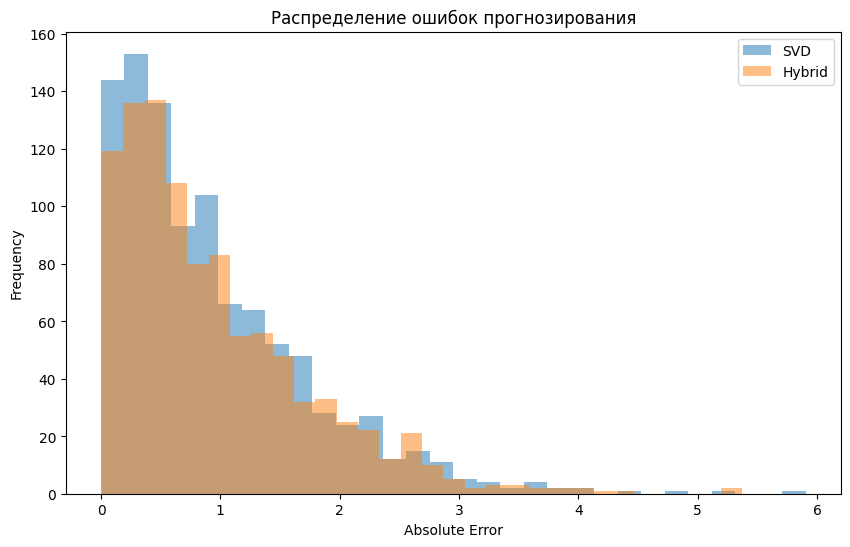

In [ ]:
import matplotlib.pyplot as plt

svd_errors = []
hybrid_errors = []

for svd_pred, hybrid_pred in zip(svd_predictions, hybrid_predictions):
    # Для SVD
    uid, iid, true_r, est, _ = svd_pred
    svd_errors.append(abs(est - true_r))

    # Для гибридной модели
    uid, iid, true_r, est, _ = hybrid_pred
    hybrid_errors.append(abs(est - true_r))

# Визуализация
plt.figure(figsize=(10, 6))
plt.hist(svd_errors, bins=30, alpha=0.5, label='SVD')
plt.hist(hybrid_errors, bins=30, alpha=0.5, label='Hybrid')
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')
plt.title('Распределение ошибок прогнозирования')
plt.legend()
plt.show()

Сравнение моделей:

Гибридная модель демонстрирует более высокую частоту малых ошибок (в диапазоне 1-2) по сравнению с SVD, что указывает на её улучшенную точность.

SVD показывает более высокую частоту больших ошибок (3+), что говорит о том, что гибридный подход лучше справляется со сложными случаями.



Эффективность гибридизации:

Разница в распределениях подтверждает, что добавление контентной фильтрации к коллаборативной (SVD) улучшает качество рекомендаций.

Гибридный подход снижает количество крупных ошибок, что особенно важно для пользовательского опыта.
